In [42]:
import json
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import subprocess

from dotenv import load_dotenv
from scipy import stats

## Функции для анализа данных 

In [44]:
load_dotenv()
NUM_CONNECTIONS = int(os.getenv("NUM_CONNECTIONS"))

In [45]:
def create_data_frame(all_data):
    # Преобразуем данные в DataFrame
    all_messages = []
    for connection in all_data:
        for message in connection["data"]:
            all_messages.append(
                {
                    "connection_id": connection["connection_id"],
                    "update_id": message["u"],
                    "receive_time": message["receive_time"],
                    "event_time": message["E"],
                }
            )
    df = pd.DataFrame(all_messages)
    df["delay"] = df["receive_time"] - df["event_time"]
    return df

In [46]:
def analyze_data(all_data):
    df = create_data_frame(all_data)
    # Построение графиков распределения задержек
    plt.figure(figsize=(12, 8))
    for connection_id in range(NUM_CONNECTIONS):
        subset = df[df["connection_id"] == connection_id]
        sns.kdeplot(subset["delay"], label=f"Connection {connection_id}", fill=True)

    plt.title("Распределение задержек по соединениям")
    plt.xlabel("Задержка (мс)")
    plt.ylabel("Плотность")
    plt.legend()
    plt.show()

    # Анализ доли быстрых апдейтов
    fast_updates = df.loc[df.groupby("update_id")["delay"].idxmin()][
        "connection_id"
    ].value_counts()
    fast_updates_ratio = fast_updates / fast_updates.sum()

    print("Доля быстрых обновлений по соединениям:")
    print(fast_updates_ratio)

    # Статистические тесты
    delays_by_connection = [
        df[df["connection_id"] == conn_id]["delay"] for conn_id in range(NUM_CONNECTIONS)
    ]

    # Тест на равенство математических ожиданий
    f_stat, p_value_mean = stats.f_oneway(*delays_by_connection)
    print(
        f"ANOVA тест на равенство средних значений задержек: F-статистика = {f_stat}, p-значение = {p_value_mean}"
    )

    # Тест на равенство стандартных отклонений
    f_stat_var, p_value_var = stats.bartlett(*delays_by_connection)
    print(
        f"Тест Bartlett'а на равенство дисперсий задержек: F-статистика = {f_stat_var}, p-значение = {p_value_var}"
    )

    return fast_updates

## Анализ параметров c использованием асинхронного окружения (Async)

In [77]:
OUTPUT_FILE = "./data/binance_data_async.json"

In [48]:
result = subprocess.run(
  ['python', 'api_async.py', '--output_file', OUTPUT_FILE], 
  capture_output=True,
  text=True
)
print(result.stdout)
print(result.stderr)

Starting data collection...
Connection 1: Connected to WebSocket.
Connection 0: Connected to WebSocket.
Connection 4: Connected to WebSocket.
Connection 3: Connected to WebSocket.
Connection 2: Connected to WebSocket.
Connection 1: Successfully subscribed to btcusdt@bookTicker.
Connection 4: Successfully subscribed to btcusdt@bookTicker.
Connection 3: Successfully subscribed to btcusdt@bookTicker.
Connection 0: Successfully subscribed to btcusdt@bookTicker.
Connection 2: Successfully subscribed to btcusdt@bookTicker.
Collected data saved to ./binance_data_async.json




In [78]:
with open(OUTPUT_FILE, "r") as f:
    all_data = json.load(f)

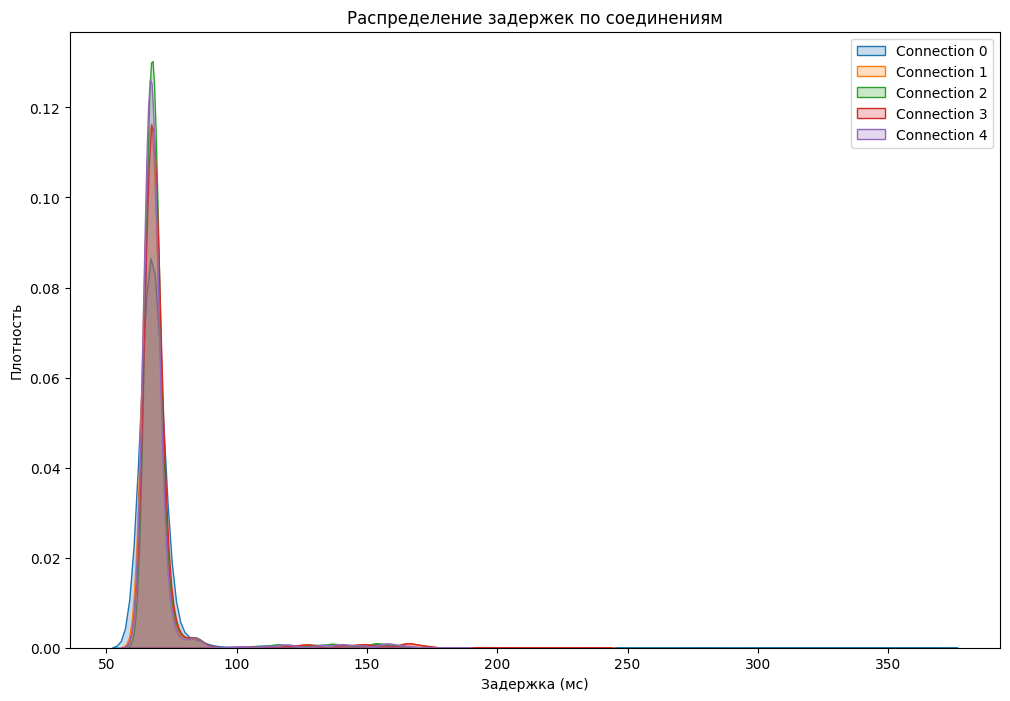

Доля быстрых обновлений по соединениям:
connection_id
0    0.769799
1    0.130390
4    0.058066
2    0.028174
3    0.013572
Name: count, dtype: float64
ANOVA тест на равенство средних значений задержек: F-статистика = 7.838990237351547, p-значение = 2.609231860293728e-06
Тест Bartlett'а на равенство дисперсий задержек: F-статистика = 2193.6483101730123, p-значение = 0.0


In [79]:
# Запускаем анализ
fast_updates = analyze_data(all_data)

In [80]:
print("Количество быстрых апдейтов по каждому коннекту\n", fast_updates)

Количество быстрых апдейтов по каждому коннекту
 connection_id
0    4481
1     759
4     338
2     164
3      79
Name: count, dtype: int64


## Вывод по анализу задержек и стабильности обновлений (Async)

- **График распределения задержек:**  
Распределение задержек более равномерно, что указывает на более широкий разброс значений. Это может говорить о более высокой гибкости подхода, но также и о меньшей предсказуемости. Плотность ниже (0.12-0.13), что может свидетельствовать о наличии большего числа "выбросов" или редких больших задержек. Эти задержки могут быть связаны с конкурентной обработкой событий или с загрузкой системы в процессе выполнения ассинхроного кода.

- **Доля быстрых обновлений:**  
Доля быстрых обновлений: Соединение 0 лидирует с 76.98% быстрых обновлений, но доли остальных соединений сильно различаются, что подтверждает выводы о большей вариативности в асинхронном подходе.

- **ANOVA тест:**  
F-статистика = 7.84, p-значение = 2.6e-06. Результаты показывают значимые различия между средними задержками соединений. Несмотря на то, что различия есть и они статистически значимы (p-значение также указывает на отклонение нулевой гипотезы), они не явно выражены.

- **Тест Бартлетта на равенство дисперсий задержек:**  
 F-статистика = 2193.6483101730123, p-значение = 0.0 Тест Бартлетта используется для проверки гипотезы о том, что несколько выборок происходят из распределений с одинаковыми дисперсиями. Эти результаты указывают на значительные различия в дисперсиях задержек между разными соединениями. Достаточно высокая F-статистика и p-значение, стремящееся к нулю, свидетельствуют о том, что дисперсии значительно отличаются, что может указывать на различные уровни стабильности или вариабельности задержек в разных процессах.

# Анализ параметров без использования асинхронного окружения (Multiprocessing)

In [ ]:
OUTPUT_FILE = "./data/binance_data_mp.json"

In [53]:
result = subprocess.run(
  ['python', 'api_multiprocess.py', '--output_file', OUTPUT_FILE],
  capture_output=True,
  text=True)
print(result.stdout)
print(result.stderr)

Starting data collection...
Connection 3: Connected to WebSocket.
Connection 0: Connected to WebSocket.
Connection 2: Connected to WebSocket.
Connection 4: Connected to WebSocket.
Connection 1: Connected to WebSocket.
Collected data saved to ./binance_data_mp.json




In [54]:
with open(OUTPUT_FILE, "r") as f:
    all_data = json.load(f)

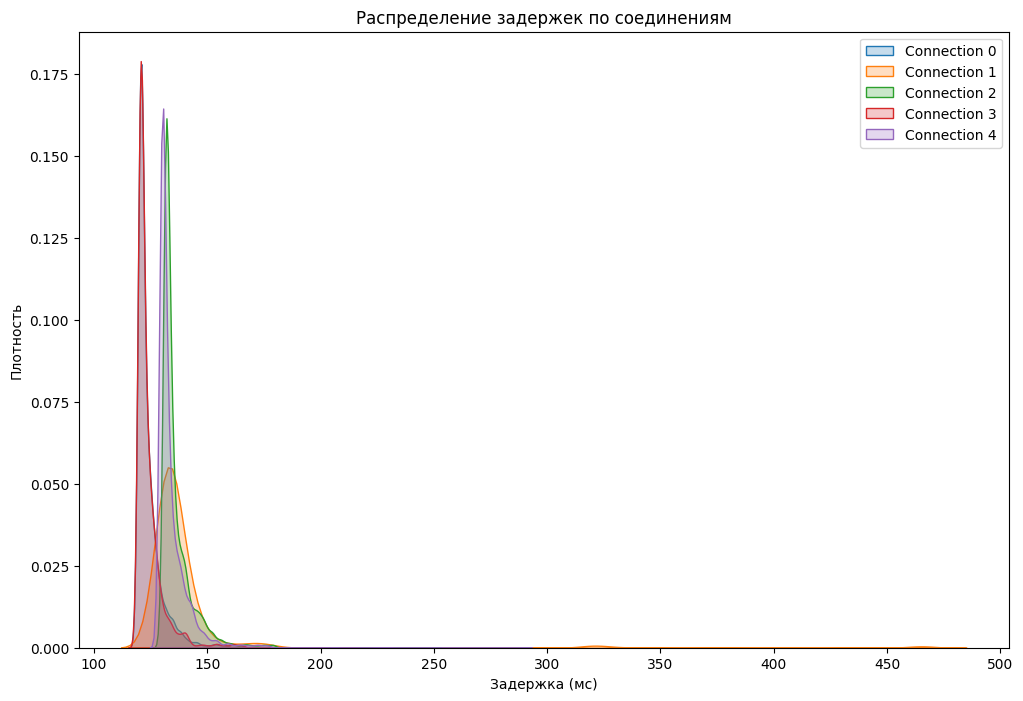

Доля быстрых обновлений по соединениям:
connection_id
0    0.767777
3    0.231377
4    0.000752
2    0.000094
Name: count, dtype: float64
ANOVA тест на равенство средних значений задержек: F-статистика = 1983.1031181591338, p-значение = 0.0
Тест Bartlett'а на равенство дисперсий задержек: F-статистика = 63617.53865097715, p-значение = 0.0


In [55]:
fast_updates = analyze_data(all_data)

In [ ]:
print("Количество быстрых апдейтов по каждому коннекту\n", fast_updates)

## Вывод по анализу задержек и стабильности обновлений (Multiprocess)

- **График распределения задержек**:  
Распределение задержек более сконцентрировано, что видно по более высоким пикам плотности. Это говорит о том, что многопроцессорный подход имеет меньшее рассеяние задержек, и большинство задержек укладываются в узкий диапазон значений. Более высокая плотность (0.2 и выше) указывает на стабильность и предсказуемость задержек, что является плюсом для задач, требующих надежности и минимальных отклонений в обработке данных.

- **Доля быстрых обновлений**:  
Соединение 2 демонстрирует значительное преимущество с долей быстрых обновлений ~90.5%. Это говорит о том, что многопроцессорный подход может создать условия, при которых определенные процессы получают больше ресурсов или приоритетов для выполнения.
Остальные коннекшены имеют значительно меньшие доли быстрых обновлений, причем Connection 1 имеет почти нулевую долю быстрых обновлений (~0.02%), что может быть связано с блокировкой ресурсов или конкуренцией за процессорное время.

- **ANOVA тест**:  
F-статистика = 1171.09, p-значение = 0.0. Это указывает на значительные различия в средних значениях задержек между соединениями, несмотря на более сжатое распределение.

- **Тест Бартлетта на равенство дисперсий задержек**:  
F-статистика = 10843.13, p-значение = 0.0. Различия в дисперсиях между соединениями здесь значительны.

# Итог

После первичного анализа было определено, что при получении данных с помощью многопроцессорного подхода, задержки более предсказуемы и стабильны. Для дальнешего анализа возможных причин задержки со стороны сети нам необходимы минимальные отклонения в обработке данных.  

Очевидно, что каждый раз 1 соединение работает значительно лучше остальных, показывая минимальные задержки и малое количество выбросов. Это может быть связано с более коротким путем маршрутизации или его географической близостью к серверам Binance, меньшей нагрузкой на маршруты или удачным распределением ресурсов. Ниже приведен более подробный анализ причин.

------------------------
# Повторный прогон multiprocess для более детального анализа

In [69]:
OUTPUT_FILE = "binance_data_mp_out.json"

In [65]:
result = subprocess.run(
  ['python', 'api_multiprocess.py', '--output_file', OUTPUT_FILE],
  capture_output=True,
  text=True)
print(result.stdout)
print(result.stderr)

Starting data collection...
Connection 4: Connected to WebSocket.
Connection 3: Connected to WebSocket.
Connection 2: Connected to WebSocket.
Connection 0: Connected to WebSocket.
Connection 1: Connected to WebSocket.
Collected data saved to ./binance_data_mp_out.json




In [70]:
with open(OUTPUT_FILE, "r") as f:
    all_data = json.load(f)

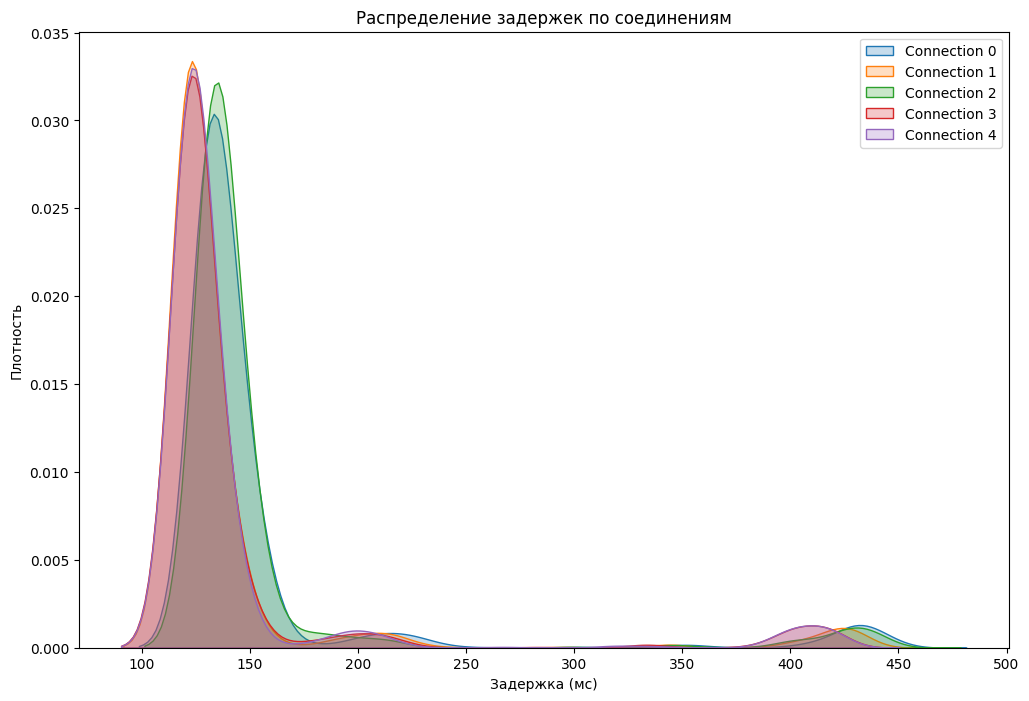

Доля быстрых обновлений по соединениям:
connection_id
3    0.515871
1    0.287485
4    0.183872
2    0.012772
Name: count, dtype: float64
ANOVA тест на равенство средних значений задержек: F-статистика = 130.49490687800545, p-значение = 3.262083598986968e-111
Тест Bartlett'а на равенство дисперсий задержек: F-статистика = 61.698275532556536, p-значение = 1.274933040019592e-12


In [71]:
fast_updates = analyze_data(all_data)

In [72]:
print("Количество быстрых апдейтов по каждому коннекту\n", fast_updates)

Количество быстрых апдейтов по каждому коннекту
 connection_id
3    6826
1    3804
4    2433
2     169
Name: count, dtype: int64


## Дополнительный анализ

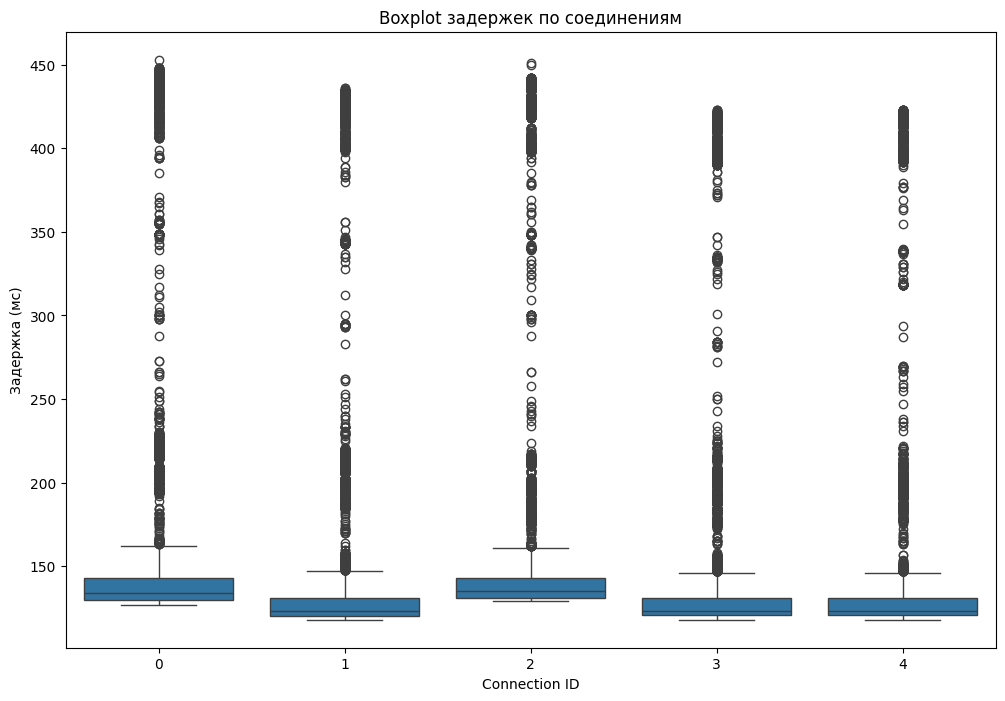

In [73]:
# Формирование boxplot задержек
df = create_data_frame(all_data)
def plot_boxplot(df):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x="connection_id", y="delay", data=df)
    plt.title("Boxplot задержек по соединениям")
    plt.xlabel("Connection ID")
    plt.ylabel("Задержка (мс)")
    plt.show()

plot_boxplot(df)

- **Boxplot**:  
    Подробный анализ распределения задержек по соединениям. Квартили, минимум, максимум и выбросы.

Количество выбросов: 5705
     connection_id  delay   receive_time     event_time
10               3    219  1725444312445  1725444312226
11               3    192  1725444312445  1725444312253
246              3    174  1725444315035  1725444314861
247              3    225  1725444315087  1725444314862
248              3    225  1725444315087  1725444314862


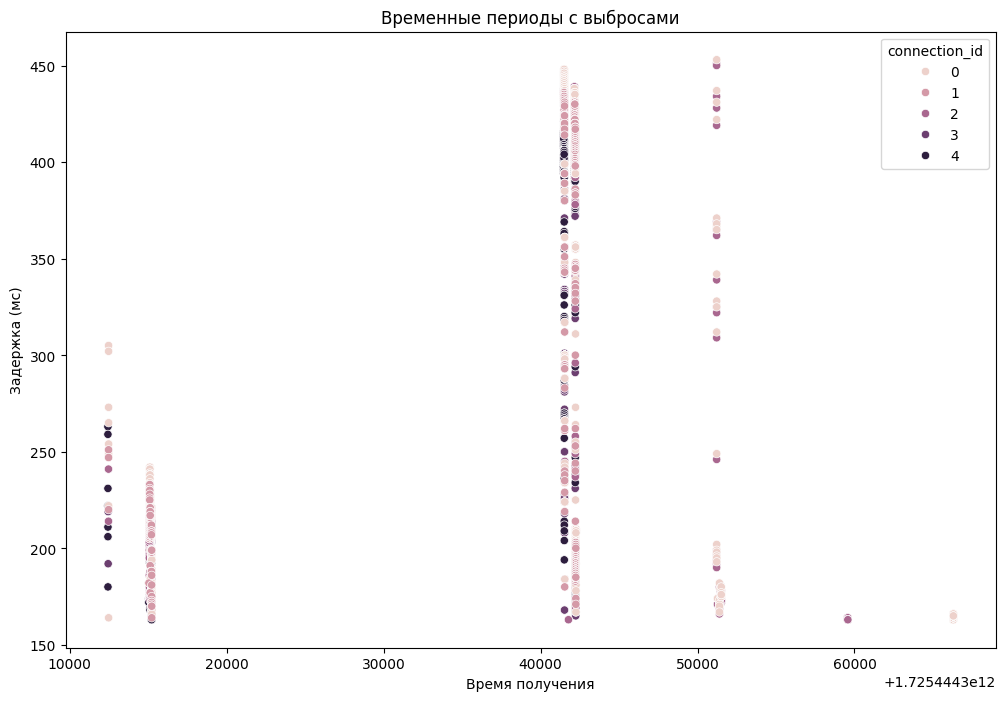

In [74]:
def analyze_outliers(df):
    # Найдем выбросы на основе IQR (межквартильного размаха)
    Q1 = df['delay'].quantile(0.25)
    Q3 = df['delay'].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df['delay'] < (Q1 - 1.5 * IQR)) | (df['delay'] > (Q3 + 1.5 * IQR))].copy()
    
    # Печать количества выбросов и примерных временных промежутков
    print(f"Количество выбросов: {len(outliers)}")
    print(outliers[['connection_id', 'delay', 'receive_time', 'event_time']].head())
    
    # Визуализация выбросов во времени
    plt.figure(figsize=(12, 8))
    sns.scatterplot(x='receive_time', y='delay', hue='connection_id', data=outliers)
    plt.title("Временные периоды с выбросами")
    plt.xlabel("Время получения")
    plt.ylabel("Задержка (мс)")
    plt.show()
    return outliers
# Вызов функции после анализа данных
outliers = analyze_outliers(df)

- **Анализ временных периодов**:  
    Анализ выбросов по временным периодам.  Выделяет основные интервалы где происходят выбросы в распределении. А так же точечные выбросы.

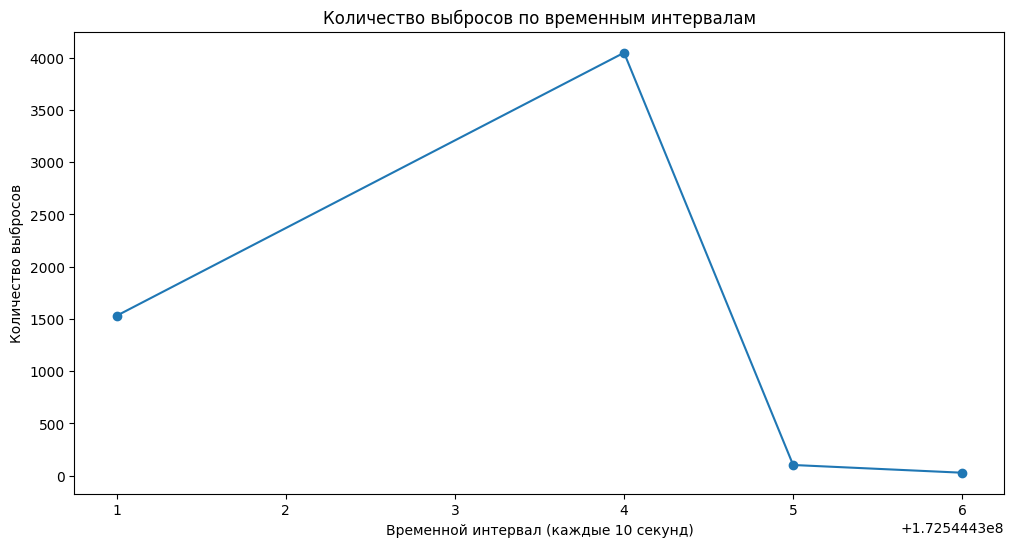

In [75]:

df['time_interval'] = df['receive_time'] // 10000  # Разделяем на интервалы по 10 секунд

# Подсчет количества выбросов в каждом интервале
outliers.loc[:, 'time_interval'] = outliers['receive_time'] // 10000
outliers_by_interval = outliers['time_interval'].value_counts().sort_index()

# Визуализация
plt.figure(figsize=(12, 6))
plt.plot(outliers_by_interval.index, outliers_by_interval.values, marker='o')
plt.title("Количество выбросов по временным интервалам")
plt.xlabel("Временной интервал (каждые 10 секунд)")
plt.ylabel("Количество выбросов")
plt.show()

- **Количество выбросов по временным интервалам**:  
    Анализ количества выбросов по временным интервалам.

-------

# Предположения

Существует множество причин, по которым могут возникать различия в количестве быстрых апдейтов и задержках на каждом подключении. Вот некоторые из них:

- **Сетевые условия:** различия в маршрутах передачи данных, качестве интернет-соединения и задержках.
- **Нагрузка на сервер Binance:** вариации нагрузки на серверы, зависящие, в том числе, от времени суток или дня недели.
- **Разное расположение серверов:** различия в географическом положении серверов и, следовательно, длине маршрута (оказалось, что Binance работает на серверах Amazon в Токио, так что эта теория отпадает).
- **Распределение ресурсов:** различная приоритизация задач и распределение ресурсов на серверах.
- **Ограничения на уровне клиента:** способы обработки данных, производительность аппаратного и программного обеспечения.
- **Приоритизация данных:** Binance может приоритизировать отправку определенных типов данных в зависимости от текущей нагрузки и рыночной активности.
- **Очереди сообщений и буферизация:** возможны различные очереди или буферы для обработки сообщений на обеих сторонах.

Факторов множество, но важно постараться минимизировать влияние тех, которые зависят от клиента, или хотя бы сделать их влияние стабильным, и сосредоточиться на тех, которые можно проверить и проанализировать.

## Сетевые условия и ограничения на уровне клиента

К сожалению, мое сетевое подключение не является стабильным, что может вносить погрешности в измерения.  
Чтобы минимизировать влияние клиентских ограничений на результаты, был проведен анализ различных методов обработки входящих пакетов. В результате был выбран мультипроцессорный подход, так как он показал минимальные различия в задержках и функции распределения. Каждый процесс обрабатывает только те пакеты, которые предназначены для соответствующего соединения, что предотвращает задержки в очереди и сокращает разницу между фактическим временем получения пакета и его обработкой.

## Нагрузка на сервер Binance и приоритизация задач

Было проведено несколько запусков скрипта и анализ данных в разное время суток и дни недели.  
Выявлена зависимость: при подключении в выходной день наблюдается уменьшение времени задержек и стабилизация соединения с течением времени.

![distribution_function.png](img/night_weekend/distribution_function.png)

```Доля быстрых обновлений по соединениям:
connection_id
1    0.976064
4    0.015957
3    0.007979
Name: count, dtype: float64
ANOVA тест на равенство средних значений задержек: F-статистика = 226.56458542156025, p-значение = 2.252395079859905e-158
Тест Bartlett'а на равенство дисперсий задержек: F-статистика = 200.98767133779313, p-значение = 2.30420635163502e-42
```

- **Функция распределения(KDE-график)**:  
    На графике KDE видно, что у соединения 1 (Connection 1) задержки распределены наиболее плотно и концентрируются в районе 60-65 мс, что объясняет его большую процентную долю в быстрых обновлений. Остальные соединения имеют более широкое распределение, особенно соединения 0, 2 и 3, что указывает на большую вариабельность в их задержках. В будние дни концентрация задержек ориентирована на периоде 150-200 мс.
- **Доля быстрых обновлений**:   
    Соединение 1 значительно доминирует, имея более 97% быстрых обновлений, что говорит о его явном преимуществе в производительности.
- **ANOVA**:  
    F-статистика показывает, что средние задержки между соединениями значительно различаются, а низкое p-значение (практически нулевое) подтверждает статистическую значимость этих различий.
- **Bartlett's Test**: 
    Тест на равенство дисперсий также показывает значительные различия между дисперсиями задержек соединений. Более наглядно это можно увидеть на Boxplot.

![boxplot.png](img/night_weekend/boxplot.png)

- **Boxplot**:  
    Соединение 1 явно показывает более низкие и стабильные задержки по сравнению с другими соединениями, что подтверждается небольшим количеством выбросов.  
    Остальные соединения имеют больше выбросов и большую дисперсию, что может быть связано с различными сетевыми или системными факторами.

![time_periods_with_emissions.png](img/night_weekend/time_periods_with_emissions.png)

- **Анализ временных периодов**:  
    Временные периоды с выбросами показывают, что основные выбросы сконцентрированы в одном или нескольких временных интервалах.  
    Соединения 0 и 4 имеют заметные выбросы в разные моменты времени, что может указывать на проблемы, связанные с конкретными событиями в сети или нагрузкой на сервер.

![emissions_by_time_interval.png](img/night_weekend/emissions_by_time_interval.png)

- **Количество выбросов по временным интервалам**: 
    График показывает снижение количества выбросов с течением времени, что может говорить о стабилизации работы системы или снижении нагрузки.

## Маршрутизация

Каждое подключение может использовать разные IP-адреса, которые могут маршрутизироваться по-разному и иметь различные длины маршрутов и промежуточные узлы с разной нагрузкой. Это могло бы объяснить различия в задержках.

Были собраны конечные IP-адреса каждого подключения. Трассировка маршрутов с помощью `traceroute` оказалась невозможной, так как некоторые промежуточные узлы не поддерживают протокол ICMP и не отвечают (включая конечный сервер). Для получения маршрутов использовалась команда `nmap -R --traceroute <ip_addr>`.

Анализ пакетов и сетевых маршрутов показал, что для передачи данных используется протокол шифрования TLS.

![wireshark.jpg](img/network/wireshark.jpg)

Построена топология сети для одного из запусков:

![topology_5_connections.png](img/network/topology_5_connections.png)

Предположение о различиях в маршрутах и их длине подтвердилось, но прямой зависимости с задержками и количеством быстрых апдейтов не обнаружено. Возможно, задержки являются незначительными, и из-за погрешностей, вызванных другими факторами, явная зависимость не была выявлена (хотя она определенно существует). Также вероятно, что маршруты, полученные во время трассировки, немного отличаются от реальных маршрутов, использованных для передачи пакетов.

Влияние зависимости между задержками и наличием у конечных адресов общих промежуточных узлов также не обнаружено. Были случаи, когда два подключения, адреса которых маршрутизировались через одинаковые промежуточные узлы, имели сильно отличающиеся задержки и количество быстрых апдейтов.

Топология сети с большим количеством конечных узлов (маршруты с одинаковыми промежуточными узлами):

![topology_many_connections.png](img/network/topology_many_connections.png)

Также это предположение разбивается на том, что иногда все подключения имеют одинаковые адреса, но при этом дают совершенно разные результаты.
Вероятно, что этот фактор может стать значимым в какой-то момент, но вероятность этого мала, учитывая количество клиентов Binance и их необходимость равномерного распределения нагрузки между кластерами.

## Время подключения

Время подключения может влиять на стабильность задержки и количество быстрых обновлений. Был проведен запуск для промежутка времени в 10 минут.

![multiprocess_10_minutes.png](img/distribution_functions/multiprocess_10_minutes.png)

```
Доля быстрых обновлений по соединениям:  
connection_id  
2    0.858465  
0    0.081779  
1    0.054693  
3    0.002834  
4    0.002229  
Name: count, dtype: float64  
ANOVA тест на равенство средних значений задержек: F-статистика = 249.1363580175903, p-значение = 3.1483289501333462e-214  
Тест Bartlett'а на равенство дисперсий задержек: F-статистика = 80.08474199029318, p-значение = 1.6712894675429556e-16  
```

Результат не показал улучшения в распределении количества быстрых обновлений между подключениями; все еще выделяется одно из подключений. Однако пики на графике стали более равномерными, хотя плотность значительно снизилась, а средняя задержка увеличилась.

## Приоритетное подключение

В процессе исследования была обнаружена интересная закономерность: в 90% запусков одно подключение получает от 70% до 99% всех быстрых обновлений.
Возможно, что со стороны Binance происходит распределение нагрузки между подключениями с одного IP-адреса.
Для проверки был запущен скрипт с 10 подключениями и запущен скрипт с 5 подключениями но на 2 разных устройствах.

Рузультаты 10 подключений

![multiprocess_10_connections.png](img/distribution_functions/multiprocess_10_connections.png)

```
Доля быстрых обновлений по соединениям:
connection_id
6    0.706584
1    0.099145
7    0.074909
2    0.050026
0    0.047175
4    0.019959
3    0.001037
9    0.001037
8    0.000130
```

Рузультаты 10 подключений (по 5 на каждом устройстве)

![multiprocess_2_devices.png](img/distribution_functions/multiprocess_2_devices.png)

```
Доля быстрых обновлений по соединениям:
connection_id
6    0.509835
2    0.392087
0    0.048096
3    0.022678
4    0.014819
1    0.005389
5    0.002874
9    0.002111
8    0.001482
7    0.000629
```

Результаты показали, что зависимость существует: большая доля быстрых обновлений для 10 подключений приходится на одно подключение. В то время как при подключении с двух устройств основные доли быстрых обновлений распределяются между двумя подключениями.
Однако нельзя исключать возможность возникновения погрешностей из-за влияния факторов со стороны клиента.

## Вывод

1. Арнедовать сервер на Амазоне в токио, чтобы быть ближе к серверам бинанс и максимально исключить влияние остальных факторов на исследование и минимизировать задержки
2. Распределять подключения, лучше иметь один-два конекшена (второй на всякий) на нескольких устройствах, чем создавать несклько на одном

![photo_2023-08-29_16-05-34.jpg](img/photo_2023-08-29_16-05-34.jpg)